In [1]:
import pandas as pd
import torch
import numpy as np
import ast
import math
import matplotlib.pyplot as plt
from collections import Counter
import json

In [3]:
K = 10
L = 4
d = 16
T = 4
token_choice = 'random'
part_1 = 'P1'
part_2 = 'P2'
ITN = 8000
lr = 0.01

# Part 1: Open files



In [17]:
def after_open_results(df_results_open):

    col_dict_tensor = ['dictionary', 'test_X_12cb', 'test_z_12cb']
    col_dict_array = ['W_svm_12cb', 'W_tau_12cb', 'last_W_12cb']
    col_list = ['correlation_1', 'correlation_2', 'correlation_cb']
    col_dict = ['empir_TPG_12cb', 'training_data', 'SCC_12cb', 'testing_data', 'testing_data_new' 'test_SCC_12cb']
    col_dict_str = ['dictionary']
    col_tensor = ['pseudo_Vocab']
    for col in df_results_open.columns:

        if df_results_open[col].dtype == 'object' and col != 'token_choice':

            for i in df_results_open.index:

                if col in col_dict_tensor:
                    for key, value in df_results_open[col][i].items():
                        if type(value) != torch.tensor:
                            df_results_open[col][i][key] = torch.tensor(df_results_open[col][i][key], dtype=torch.float64)
                if col in col_dict_str:
                    df_results_open.at[i, col] = {int(key): value for key, value in df_results_open.at[i, col].items()}

                if col in col_dict_array:
                    for key, value in df_results_open[col][i].items():
                        if type(value) != np.ndarray:
                            df_results_open[col][i][key] = np.array(df_results_open[col][i][key])

                if col in col_tensor:
                    if type(df_results_open.loc[i, col]) != torch.tensor:
                        df_results_open.at[i, col] = torch.tensor(df_results_open.at[i, col], dtype=torch.float64)
        else:
            df_results_open[col] = df_results_open[col]

    return df_results_open

#### Read Results file

In [ ]:
train_file_1 = f'file_path/K={K}_L={L}_d={d}_T={T}_{token_choice}_lr={lr}_train_{part_1}.json'
df_results_open_1 = pd.read_json(train_file_1)
df_results_open_1 = after_open_results(df_results_open_1)

train_file_2 = f'file_path/K={K}_L={L}_d={d}_T={T}_{token_choice}_lr={lr}_train_{part_2}.json'
df_results_open_2 = pd.read_json(train_file_2)
df_results_open_2 = after_open_results(df_results_open_2)

Combine two results files

In [ ]:
df_results_open_2['current_epoch'] += len(df_results_open_1)
df_results_open = pd.concat([df_results_open_1, df_results_open_2])
df_results_open = df_results_open.reset_index(drop=True)
len(df_results_open)

# Part 2: Convergence

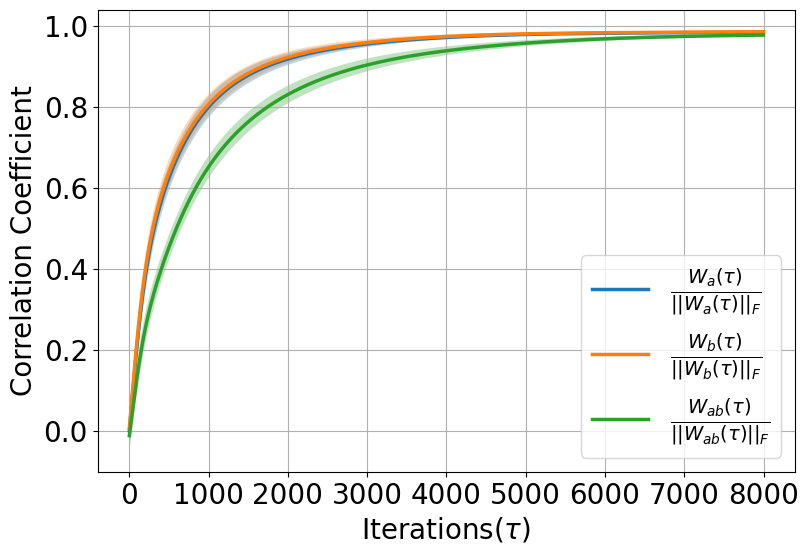

In [8]:
x = np.arange(ITN)
corr_1 = df_results_open['correlation_1']
corr_2 = df_results_open['correlation_2']
corr_cb = df_results_open['correlation_cb']

corr_ary_1 = np.array([np.array(lst) for lst in corr_1])
corr_ary_2 = np.array([np.array(lst) for lst in corr_2])
corr_ary_cb = np.array([np.array(lst) for lst in corr_cb])

avg_corr_1 = np.mean(corr_ary_1, axis=0)
avg_corr_2 = np.mean(corr_ary_2, axis=0)
avg_corr_cb = np.mean(corr_ary_cb, axis=0)

std_corr_1 = np.std(corr_ary_1, axis=0) / np.sqrt(corr_ary_1.shape[0])
ci_corr_1 = 1.96 * std_corr_1
std_corr_2 = np.std(corr_ary_2, axis=0) / np.sqrt(corr_ary_2.shape[0])
ci_corr_2 = 1.96 * std_corr_2
std_corr_cb = np.std(corr_ary_cb, axis=0) / np.sqrt(corr_ary_cb.shape[0])
ci_corr_cb = 1.96 * std_corr_cb

plt.figure(figsize=(9, 6))
plt.plot(x, avg_corr_1, label=r'$\frac{W_a(\tau)}{||W_a(\tau)||_F}$', linewidth=2.5)
plt.plot(x, avg_corr_2, label=r'$\frac{W_b(\tau)}{||W_b(\tau)||_F}$', linewidth=2.5)
plt.plot(x, avg_corr_cb, label=r'$\frac{W_{ab}(\tau)}{||W_{ab}(\tau)||_F}$', linewidth=2.5)
plt.fill_between(x, avg_corr_1 - 2*ci_corr_1, avg_corr_1 + 2*ci_corr_1, alpha=0.3)
plt.fill_between(x, avg_corr_2 - 2*ci_corr_2, avg_corr_2 + 2*ci_corr_2, alpha=0.3)
plt.fill_between(x, avg_corr_cb - 2*ci_corr_cb, avg_corr_cb + 2*ci_corr_cb, alpha=0.3)

plt.xlabel(r'Iterations$(\tau)$', fontsize = 20)
plt.ylabel('Correlation Coefficient', fontsize = 20)
legend = plt.legend(loc='best')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.grid(True)
plt.show()

# Part 3: Priority Similarity

### Get test_X and test_z in Results file

In [9]:
n = 100

In [10]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)

def get_X_new(data, dict_token):

      input_X = []

      for item in data:
          key_sequence = item[0]  # Extract the token ID in each sequence
          values = [dict_token[key].tolist() for key in key_sequence]  # Get the corresponding values from dict_token
          input_X.append(values)

      input_X = torch.tensor(input_X)
      X = input_X.double() #dtype: torch.float64
      return X

def get_X_z(data, dict_token, toy_case, batch_toy):

    X = get_X_new(data, dict_token)
    if toy_case and batch_toy:
        input_z = []
        for i in range(len(X)):
            zi = X[i][-1]
            input_z.append(zi)
        input_z = torch.stack(input_z)
        assert input_z.shape == (n, d)
    else:
        input_z = X[:, -1].unsqueeze(1) # [n, d]

    z = input_z.double() #dtype: torch.float64
    return X, z

In [11]:
toy_case = False
batch_toy = False

test_X_12cb_lst_data = []
test_z_12cb_lst_data = []

test_X_12cb_lst_data_new = []
test_z_12cb_lst_data_new = []

for ei in range(len(df_results_open)):
    test_X_12cb_data = {}
    test_z_12cb_data = {}

    test_X_12cb_data_new = {}
    test_z_12cb_data_new = {}

    data = df_results_open['testing_data'][ei]['test_topic_1'] # test data with T=4
    data_new = df_results_open['testing_data_new'][ei]['test_topic_1'] # test data with T=8

    dict_token = df_results_open['dictionary'][ei]

    # get X and z for the testing data with T=4
    X_data, z_data = get_X_z(data = data, dict_token = dict_token, toy_case = False, batch_toy = False)
    test_X_12cb_data['test_topic_1'] = X_data
    test_z_12cb_data['test_topic_1'] = z_data

    test_X_12cb_lst_data.append(test_X_12cb_data)
    test_z_12cb_lst_data.append(test_z_12cb_data)

    # get X and z for the testing data with T=8
    X_data_new, z_data_new = get_X_z(data = data_new, dict_token = dict_token, toy_case = False, batch_toy = False)
    test_X_12cb_data_new['test_topic_1'] = X_data_new
    test_z_12cb_data_new['test_topic_1'] = z_data_new

    test_X_12cb_lst_data_new.append(test_X_12cb_data_new)
    test_z_12cb_lst_data_new.append(test_z_12cb_data_new)

df_results_open['test_X_12cb'] = test_X_12cb_lst_data
df_results_open['test_z_12cb'] = test_z_12cb_lst_data

df_results_open['test_X_12cb_new'] = test_X_12cb_lst_data_new
df_results_open['test_z_12cb_new'] = test_z_12cb_lst_data_new

### Get priority similarity (T = 4)

In [12]:
def rank_similarity(x,y,t=1):

    def f(z, t=1):
        if z >= 0:
            return 1
        else:
            return 1 / math.exp(-z * t)

    def sort_vectors(x, y):
        if len(x) != len(y):
            raise ValueError("Vectors x and y must be of the same length.")

        # Combine x and y into pairs and sort by the values of x, then by y if x values are equal
        sorted_pairs = sorted(zip(x, y), key=lambda pair: (pair[0], pair[1]), reverse=True)

        # Unpack the sorted pairs back into separate vectors
        sorted_x, sorted_y = zip(*sorted_pairs)

        return list(sorted_x), list(sorted_y)

    sorted_x,sorted_y = sort_vectors(x,y)

    total_sum = 0
    for i in range(len(sorted_y)-1):
        z = sorted_y[i] - sorted_y[i+1]
        total_sum += f(z,t)

    return total_sum / (len(y)-1)

def softrank_dist_itn_file(ei, df_results, Weight_1 = 'last_W_1', Weight_cb = 'last_W_cb',
                           data =   'testing_data',
                           X = 'test_X_12cb', z = 'test_z_12cb', test_topic = 'test_topic_1', t = 5):

    sr_dist_1cb = {} # rank_similarity W_1 vs W_cb
    sr_dist_2cb = {} # rank_similarity W_2 vs W_cb
    Weight_1_val = {}
    Weight_2_val = {}
    Weight_cb_val = {}

    for id in range(len(df_results[data][ei][test_topic])):

        sr_dist_1cb[id] = []
        sr_dist_2cb[id] = []
        Weight_1_val[id] = []
        Weight_2_val[id] = []
        Weight_cb_val[id] = []

        X_i = df_results[X][ei][test_topic][id].numpy()
        X_i_transpose = X_i.T
        z_test_i= df_results[z][ei][test_topic][id].numpy()
        z_i_transpose = z_test_i.T

        for i in range(ITN // 8):
            W_1_itn = df_results['W_tau_12cb'][ei]['data_topic_1'][0][i]
            W_2_itn = df_results['W_tau_12cb'][ei]['data_topic_2'][0][i]
            W_cb_itn = df_results['W_tau_12cb'][ei]['data_combine'][0][i]

            XWz_1_itn = X_i @ (W_1_itn @ z_i_transpose)
            XWz_1_itn = [item for item in XWz_1_itn.reshape(-1)]
            results_1 = softmax(XWz_1_itn) # softmax_output of each tau for topic 1
            Weight_1_val[id].append(results_1)

            XWz_2_itn = X_i @ (W_2_itn @ z_i_transpose)
            XWz_2_itn = [item for item in XWz_2_itn.reshape(-1)]
            results_2 = softmax(XWz_2_itn) # softmax_output of each tau from topic 2
            Weight_2_val[id].append(results_2)

            XWz_cb_itn = X_i @ (W_cb_itn @ z_i_transpose)
            XWz_cb_itn = [item for item in XWz_cb_itn.reshape(-1)]
            results_cb = softmax(XWz_cb_itn)
            Weight_cb_val[id].append(results_cb) # softmax_output of each tau from topic combine

            sr_dist_itn_1cb = rank_similarity(results_1, results_cb, t = t)
            sr_dist_1cb[id].append(sr_dist_itn_1cb)

            sr_dist_itn_2cb = rank_similarity(results_2, results_cb, t = t)
            sr_dist_2cb[id].append(sr_dist_itn_2cb)


    return Weight_1_val, Weight_2_val, Weight_cb_val, sr_dist_1cb, sr_dist_2cb

def save_plot_softrank_file(df_predicts, test_T, case_type = None):
    if test_T == 4:
        rank_1cb = 'rank_1cb'
        rank_2cb = 'rank_2cb'
    else:
        rank_1cb = 'rank_1cb_new'
        rank_2cb = 'rank_2cb_new'

    epochs = len(df_predicts)

    dist_1cb_list = []
    dist_2cb_list = []
    seqs_id = None

    if case_type == None:
        case_type = 'all'
        for i in range(epochs):
            for id, value in df_predicts[rank_1cb][i].items():
                dist_1cb_list.append(value)
            for id, value in df_predicts[rank_2cb][i].items():
                dist_2cb_list.append(value)


    plt.figure(figsize=(10, 6))

    all_series_1 = np.array(dist_1cb_list)
    all_means_1 = np.mean(all_series_1, axis=0)
    all_stds_1 = np.std(all_series_1, axis=0) / np.sqrt(all_series_1.shape[0])
    all_ci_1 = 1.96 * all_stds_1

    all_series_2 = np.array(dist_2cb_list)
    all_means_2 = np.mean(all_series_2, axis=0)
    all_stds_2 = np.std(all_series_2, axis=0) / np.sqrt(all_series_2.shape[0])
    all_ci_2 = 1.96 * all_stds_2

    all_x = np.arange(all_series_1.shape[1])*8
    plt.plot(all_x, all_means_1, label=r'$\frac{W_a(\tau)}{||W_a(\tau)||_F}$ vs $\frac{W_{ab}(\tau)}{||W_{ab}(\tau)||_F}$')
    plt.fill_between(all_x, all_means_1 - all_ci_1, all_means_1 + all_ci_1, alpha=0.3)

    plt.plot(all_x, all_means_2, label=r'$\frac{W_b(\tau)}{||W_b(\tau)||_F}$ vs $\frac{W_{ab}(\tau)}{||W_{ab}(\tau)||_F}$')
    plt.fill_between(all_x, all_means_2 - all_ci_2, all_means_2 + all_ci_2, alpha=0.3)

    plt.xlabel(r"Iterations $(\tau)$", fontsize = 20)
    plt.ylabel("Attention priority similarity", fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.legend(fontsize = 20)

    plt.show()
    plt.close()

    if seqs_id != None:
        return seqs_id

In [13]:
"""
all sequences in test_topic_1 (T = 4)"""
rank_1cb = []
rank_2cb = []

for ei in range(len(df_results_open)):

    Weight_1_val, Weight_2_val, Weight_cb_val, sr_dist_1cb, sr_dist_2cb = softrank_dist_itn_file(ei= ei, df_results = df_results_open,
                                                                                                 Weight_1 = 'last_W_1', Weight_cb = 'last_W_cb',
                                                                                                 data = 'testing_data', X = 'test_X_12cb', z = 'test_z_12cb',
                                                                                                 test_topic = 'test_topic_1', t = 1)
    rank_1cb.append(sr_dist_1cb)
    rank_2cb.append(sr_dist_2cb)

In [15]:
df_predicts_open = pd.DataFrame()
df_predicts_open['rank_1cb'] = rank_1cb
df_predicts_open['rank_2cb'] = rank_2cb

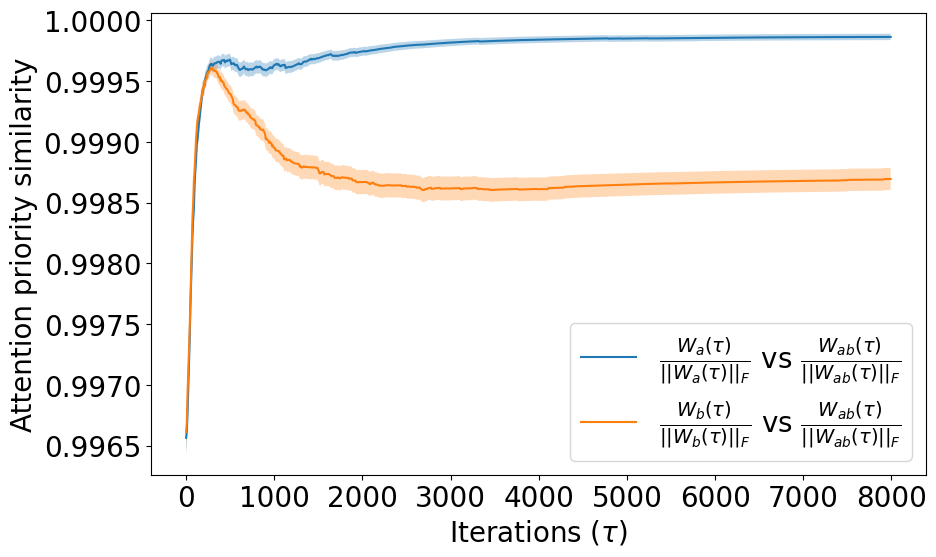

In [16]:
case_types = [None]
for case_type in case_types:
    seqs_id = save_plot_softrank_file(df_predicts = df_predicts_open, test_T = 4, case_type = case_type)